In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm

/Users/tristan/miniconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = np.array([
    [1,1,1,1,1,1],
    [1,1,1,1,1,1],
    [1,1,1,1,1,1],
    [2,2,2,2,2,2],
    [2,2,2,2,2,2],
    [2,2,2,2,2,2],
    [3,3,3,3,3,3],
    [3,3,3,3,3,3],
    [3,3,3,3,3,3],
])

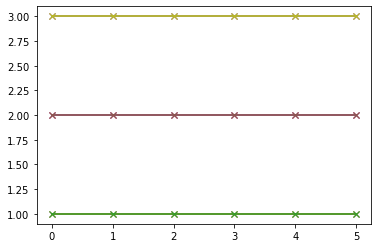

In [3]:
plt.plot(range(6), X[0], marker='x')
plt.plot(range(6), X[1], marker='x')
plt.plot(range(6), X[2], marker='x')
plt.plot(range(6), X[3], marker='x')
plt.plot(range(6), X[4], marker='x')
plt.plot(range(6), X[5], marker='x')
plt.plot(range(6), X[6], marker='x')
plt.plot(range(6), X[7], marker='x')
plt.plot(range(6), X[8], marker='x')
plt.show()

In [4]:
dataset = torch.tensor(X).unsqueeze(1).to(torch.float)
dataset.shape

torch.Size([9, 1, 6])

In [5]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn = nn.Conv1d(1,1,3,1)
        self.max_pool = nn.MaxPool1d(2,1)
        self.lstm_hidden_dim = 1
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=1,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, x):
        x = self.max_pool(F.relu(self.cnn(x)))
        x = x.permute(0, 2, 1)
        x, (_, _) = self.lstm(x)

        x = x[:, :, : self.lstm_hidden_dim] + x[:, :, self.lstm_hidden_dim :]
        x = x.permute(0,2,1)
        return x

class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Make each time series have 4 elements
        self.upsample = nn.Upsample(size=(4,))
        self.decoder = nn.ConvTranspose1d(1,1,3,1)
    
    def forward(self,x):
        x = self.upsample(x)
        return F.relu(self.decoder(x))


class TAE(nn.Module):
    def __init__(self, encoder, decoder) -> None:
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder 

    def forward(self, x):
        l = self.encoder(x)
        x_prime = self.decoder(l)
        return l, x_prime

In [41]:
encoder = Encoder()
decoder = Decoder()
ae = TAE(encoder, decoder)

optimizer = optim.Adam(ae.parameters(), lr=0.001)
criterion = nn.MSELoss()

ls = []

for i in range(10000):
    l, x_prime = ae(dataset)
    loss = criterion(x_prime, dataset)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ls.append(l.detach().numpy())
    
    if i % 100 == 0:
        print(loss.item())


4.586243629455566
4.075083255767822
3.1457762718200684
2.166351079940796
1.6108152866363525
1.3252167701721191
1.180035948753357
1.10193932056427
1.0492583513259888
0.9939630031585693
0.91880202293396
0.8050106763839722
0.6364096403121948
0.484579861164093
0.3857835829257965
0.34587082266807556
0.32704541087150574
0.3101079761981964
0.2939970791339874
0.2786540687084198
0.2640696167945862
0.250226229429245
0.23710012435913086
0.2246685028076172
0.21290728449821472
0.2018027901649475
0.19130326807498932
0.18141812086105347
0.1721203774213791
0.16339921951293945
0.1552293598651886
0.14760375022888184
0.14050538837909698
0.13391675055027008
0.12780630588531494
0.12218505144119263
0.11697288602590561
0.1122041642665863
0.10784328728914261
0.10389956831932068
0.10026191174983978
0.09700340777635574
0.094070203602314
0.09144286811351776
0.08909565955400467
0.08700856566429138
0.08515820652246475
0.08352421224117279
0.08208627998828888
0.0808267742395401
0.07972802966833115
0.0787752121686935

In [42]:
ls = [i.squeeze(1) for i in ls]

In [44]:
ls[-1]

array([[ 0.65581226,  0.6706039 ,  0.6393325 ],
       [ 0.65581226,  0.6706039 ,  0.6393325 ],
       [ 0.65581226,  0.6706039 ,  0.6393325 ],
       [ 0.00541817,  0.00346613,  0.00246736],
       [ 0.00541817,  0.00346613,  0.00246736],
       [ 0.00541817,  0.00346613,  0.00246736],
       [-0.6543003 , -0.6743157 , -0.6384683 ],
       [-0.6543003 , -0.6743157 , -0.6384683 ],
       [-0.6543003 , -0.6743157 , -0.6384683 ]], dtype=float32)

ValueError: alpha (1.01) is outside 0-1 range

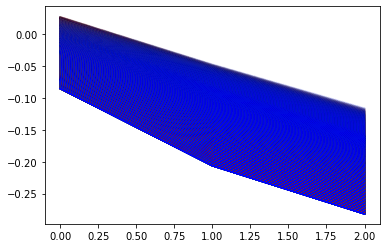

In [45]:
for i in range(len(ls)):
    for j in range(3):
        plt.plot(range(3), ls[i][0], c='r', alpha=i * 0.01)
        plt.plot(range(3), ls[i][1], c='r', alpha=i * 0.01)
        plt.plot(range(3), ls[i][2], c='r', alpha=i * 0.01)
        plt.plot(range(3), ls[i][3], c='g', alpha=i * 0.01)
        plt.plot(range(3), ls[i][4], c='g', alpha=i * 0.01)
        plt.plot(range(3), ls[i][5], c='g', alpha=i * 0.01)
        plt.plot(range(3), ls[i][6], c='b', alpha=i * 0.01)
        plt.plot(range(3), ls[i][7], c='b', alpha=i * 0.01)
        plt.plot(range(3), ls[i][8], c='b', alpha=i * 0.01)

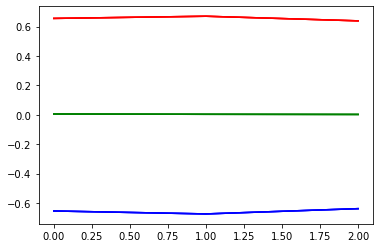

In [46]:
plt.plot(range(3), ls[-1][0], c='r', alpha=100 * 0.01)
plt.plot(range(3), ls[-1][1], c='r', alpha=100 * 0.01)
plt.plot(range(3), ls[-1][2], c='r', alpha=100 * 0.01)
plt.plot(range(3), ls[-1][3], c='g', alpha=100 * 0.01)
plt.plot(range(3), ls[-1][4], c='g', alpha=100 * 0.01)
plt.plot(range(3), ls[-1][5], c='g', alpha=100 * 0.01)
plt.plot(range(3), ls[-1][6], c='b', alpha=100 * 0.01)
plt.plot(range(3), ls[-1][7], c='b', alpha=100 * 0.01)
plt.plot(range(3), ls[-1][8], c='b', alpha=100 * 0.01)

In [14]:
l, x_prime = ae(dataset)

In [15]:
l

tensor([[[ 7.3559e-01,  7.3664e-01,  7.3454e-01]],

        [[ 7.3559e-01,  7.3664e-01,  7.3454e-01]],

        [[ 7.3559e-01,  7.3664e-01,  7.3454e-01]],

        [[ 5.9903e-06,  6.0201e-06,  2.1607e-06]],

        [[ 5.9903e-06,  6.0201e-06,  2.1607e-06]],

        [[ 5.9903e-06,  6.0201e-06,  2.1607e-06]],

        [[-7.3559e-01, -7.3663e-01, -7.3454e-01]],

        [[-7.3559e-01, -7.3663e-01, -7.3454e-01]],

        [[-7.3559e-01, -7.3663e-01, -7.3454e-01]]], grad_fn=<PermuteBackward0>)

In [16]:
cs = KMeans(n_clusters=3).fit_predict(l.detach().numpy().squeeze(1))
cs

array([2, 2, 2, 0, 0, 0, 1, 1, 1], dtype=int32)

In [17]:
centroids = []

for i in range(3):
    mask = cs == i
    centroids.append(l[mask].mean(dim=2).reshape(1, -1))

In [18]:
centroids = torch.cat(centroids).detach()

In [19]:
centroids

tensor([[ 4.7237e-06,  4.7237e-06,  4.7237e-06],
        [-7.3559e-01, -7.3559e-01, -7.3559e-01],
        [ 7.3559e-01,  7.3559e-01,  7.3559e-01]])

In [20]:
centroids = torch.tensor(centroids).unsqueeze(1).to(torch.float)
centroids.shape

/var/folders/fg/zrq1rktd2lq738r5z3wc_wt00000gn/T/ipykernel_19241/1839959827.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centroids = torch.tensor(centroids).unsqueeze(1).to(torch.float)


torch.Size([3, 1, 3])

In [21]:
# for i in range(25):
#     for j in range(3):
#         plt.plot(range(3), ls[i][0], c='r', alpha=i * 0.01)
#         plt.plot(range(3), ls[i][1], c='g', alpha=i * 0.01)
#         plt.plot(range(3), ls[i][2], c='b', alpha=i * 0.01)

# plt.plot(range(3), centroids[0], c='black')
# plt.plot(range(3), centroids[1], c='black')
# plt.plot(range(3), centroids[2], c='black')
# plt.show()

In [22]:
class ClusterLayer(nn.Module):
    def __init__(self, encoder, centroids) -> None:
        super().__init__()
        self.encoder = encoder 
        self.centroids = nn.Parameter(centroids)
    
    def euclidean_distance(self, x, y):
        dists = torch.zeros(9,3)

        for i in range(9):
            d = []
            for j in range(3):
                a = x[i].flatten()
                b = y[j].flatten()
                euc = ((a-b)**2).sum()
                dists[i][j] = euc
        return dists

    def students_t_distribution_kernel(self, x, alpha=1):
        num = torch.pow((1 + x / alpha), -(alpha + 1) / 2)
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, 3)
        return num / denom

    def target_distribution(self, Q):
        F = Q.sum(dim=0)
        num = (Q ** 2) / F
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, Q.shape[-1])
        return num / denom

    def forward(self, x):
        l = self.encoder(x)
        D = self.euclidean_distance(l, self.centroids)
        Q = self.students_t_distribution_kernel(D)
        P = self.target_distribution(Q)
        return l, torch.log(Q), torch.log(P)

In [23]:
cl = ClusterLayer(encoder=encoder, centroids=centroids)

In [24]:
optimizer = optim.SGD(cl.parameters(), lr=0.001)
mse = nn.MSELoss()
kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

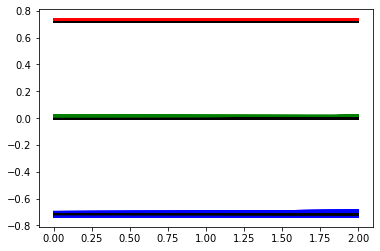

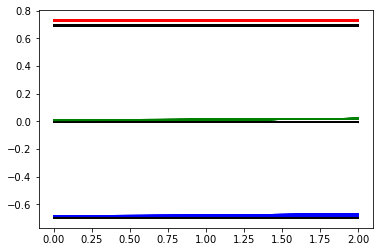

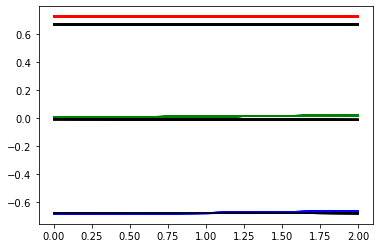

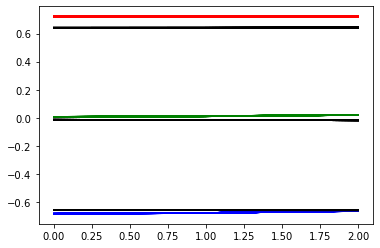

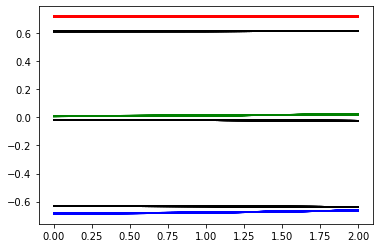

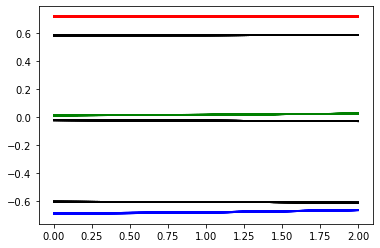

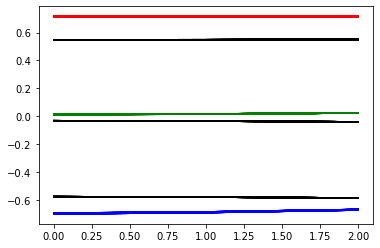

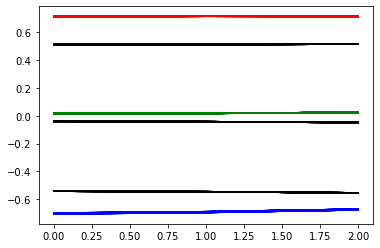

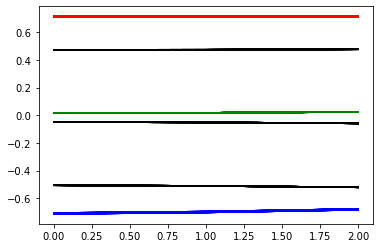

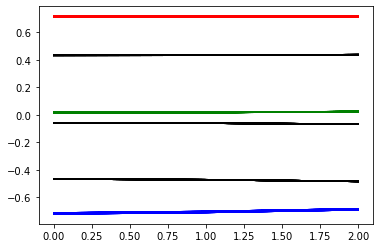

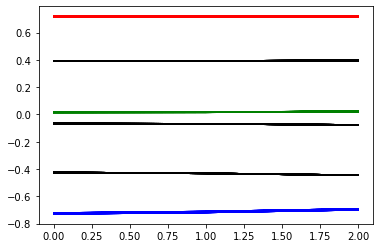

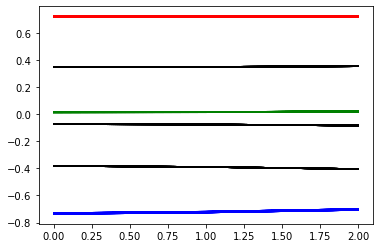

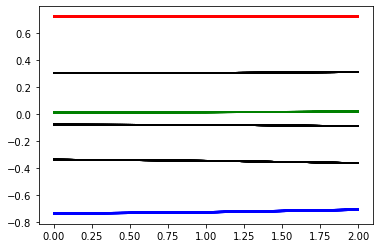

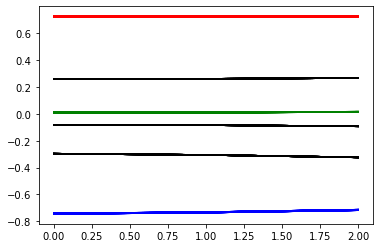

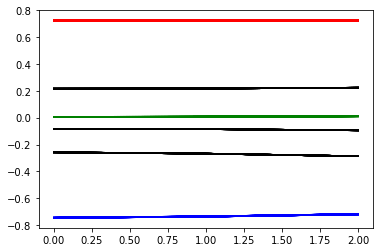

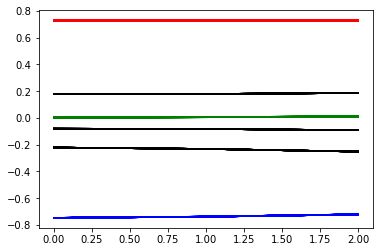

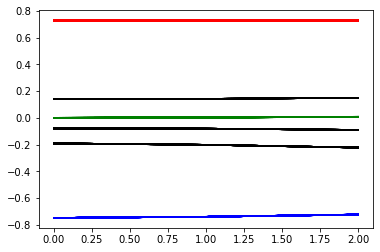

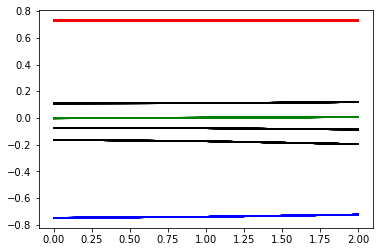

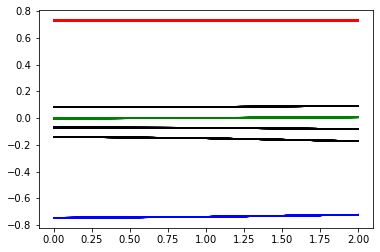

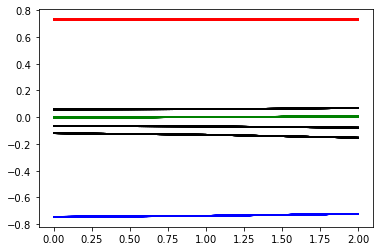

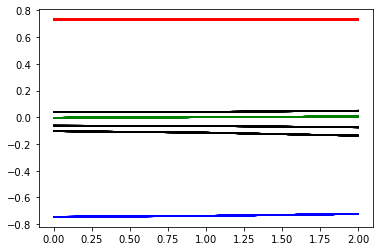

KeyboardInterrupt: 

In [25]:
mse_data = []
kl_data = []
ls = []
cents = []

for i in range(100000):
    l, P, Q = cl(dataset)
    x_prime = decoder(l)

    mse_loss = mse(dataset, x_prime)
    kl_loss = kl(Q, P)

    dtc_loss = mse_loss + kl_loss

    optimizer.zero_grad()
    dtc_loss.backward()
    optimizer.step()

    mse_data.append(mse_loss.item())
    kl_data.append(kl_loss.item())

    if i % 100 == 0:
        ls.append(l)
        cents.append(cl.centroids)

    if i % 1000 == 0:
        if i  == 0:
            continue
        ls = [i.squeeze(1).detach() for i in ls]
        cents = [i.squeeze(1).detach() for i in cents]

        for i in range(len(ls)):
            for j in range(3):
                plt.plot(range(3), ls[i][0], c='r')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][1], c='r')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][2], c='r')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][3], c='g')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][4], c='g')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][5], c='g')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][6], c='b')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][7], c='b')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][8], c='b')#, alpha=i * 0.01)
                plt.plot(range(3), cents[i][0], c='black')#, alpha=i * 0.01)
                plt.plot(range(3), cents[i][1], c='black')#, alpha=i * 0.01)
                plt.plot(range(3), cents[i][2], c='black')#, alpha=i * 0.01)

        plt.show()

        ls = []
        cents = []

* Make Gif of how thing is changing
* Then document everything

In [ ]:
mse_data = []
kl_data = []
ls = []
cents = []

for i in range(100000):
    l, P, Q = cl(dataset)
    x_prime = decoder(l)

    mse_loss = mse(dataset, x_prime)
    kl_loss = kl(Q, P)

    dtc_loss = mse_loss +  kl_loss

    optimizer.zero_grad()
    dtc_loss.backward()
    optimizer.step()

    mse_data.append(mse_loss.item())
    kl_data.append(kl_loss.item())

    if i % 100 == 0:
        ls.append(l)
        cents.append(cl.centroids)

    if i % 1000 == 0:
        if i  == 0:
            continue
        ls = [i.squeeze(1).detach() for i in ls]
        cents = [i.squeeze(1).detach() for i in cents]

        for i in range(len(ls)):
            for j in range(3):
                plt.plot(range(3), ls[i][0], c='r')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][1], c='r')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][2], c='r')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][3], c='g')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][4], c='g')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][5], c='g')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][6], c='b')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][7], c='b')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][8], c='b')#, alpha=i * 0.01)
                plt.plot(range(3), cents[i][0], c='black')#, alpha=i * 0.01)
                plt.plot(range(3), cents[i][1], c='black')#, alpha=i * 0.01)
                plt.plot(range(3), cents[i][2], c='black')#, alpha=i * 0.01)

        plt.show()

        ls = []
        cents = []


* From this experiment it seems we should add a term to repel the centroids from one another
* From output 22 we can see that is is kind of even out the probability assignments accross the clusters. This is what we saw in last experiment.\
* The AE representations stabilise much faster than the KL loss moves clusters
    * Thus we must stabilise the AE first
* Cluster centroids commonly converge
* After getting slightly perturbed cluster centres move to the centre between the AE latents

In [ ]:
plt.plot(range(len(mse_data)), mse_data)
plt.show()

In [ ]:
plt.plot(range(len(kl_data)), kl_data)
plt.show()

In [ ]:
ls = [i.squeeze(1).detach() for i in ls]
cents = [i.squeeze(1).detach() for i in cents]

In [ ]:
for i in range(len(ls)):
    for j in range(3):
        plt.plot(range(3), ls[i][0], c='r')#, alpha=i * 0.01)
        plt.plot(range(3), ls[i][1], c='g')#, alpha=i * 0.01)
        plt.plot(range(3), ls[i][2], c='b')#, alpha=i * 0.01)
        plt.plot(range(3), cents[i][0], c='black')#, alpha=i * 0.01)
        plt.plot(range(3), cents[i][1], c='black')#, alpha=i * 0.01)
        plt.plot(range(3), cents[i][2], c='black')#, alpha=i * 0.01)

In [ ]:
ls